# Лабораторная работа 1

### Цель: предсказывать факт выживания на корабле Титаник
### Задачи

* Подготовить данные для работы с k-NN
* Использовать метод k-NN при n = 5 (5 соседей)
* Определеине оптимального кол-ва соседей

Начальные данные:
Pclass — класс пассажира (1 — высший, 2 — средний, 3 — низший);
Name — имя;
Sex — пол;
Age — возраст;
SibSp — количество братьев, сестер, сводных братьев, сводных сестер, супругов на борту титаника;
Parch — количество родителей, детей (в том числе приемных) на борту титаника;
Ticket — номер билета;
Fare — плата за проезд;
Cabin — каюта;
Embarked — порт посадки (C — Шербур; Q — Квинстаун; S — Саутгемптон);

In [1]:
#импорт необходимых модулей
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Абсолютный путь до папки с данными
dataPath = '/home/alex/Downloads/bmstuML/dataMl/'


Для начала считаем файл с данными для обучения.

In [2]:
# читаем файл с данными для обучения
dataTrain = pd.read_csv(dataPath + 'train.csv',sep=',')
dataTrain.head(5)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [3]:
# просмотрим как представлены данные
dataTrain.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


### Очистка данных
Необходи очистить данные. Удалим информацию, которая для нас не информативна.Обоснование удаления:

* PassengerId - первичный ключ для объкта, не влияет
* Name - не влияет, считаем, что не спасали людей следуя алфавитному списку
* Ticket - не информативено
* Cabin - не информативно, не знаем расположение кают

Порт не удаляем, считаем, что чем раньше пассажир сел на корабль, тем больше у него было времени освоиться. (Лучше узнать план корабля)

In [4]:
dataTrain = dataTrain.drop(['PassengerId', 'Name', 'Ticket', 'Cabin'], axis='columns')
dataTrain.head(5)

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
0,0,3,male,22.0,1,0,7.2500,S
1,1,1,female,38.0,1,0,71.2833,C
2,1,3,female,26.0,0,0,7.9250,S
3,1,1,female,35.0,1,0,53.1000,S
4,0,3,male,35.0,0,0,8.0500,S


### Очистка данных, корреляция
Посмотрим корреляцию между данными, удалим данные, которые сильно коррелируют

<AxesSubplot:>

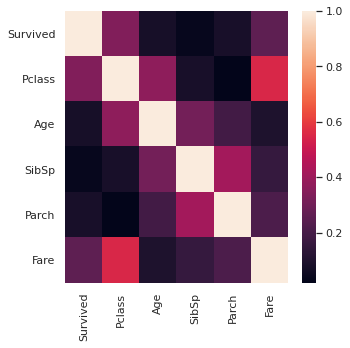

In [5]:
import seaborn as sns
corr = dataTrain.corr().abs()

sns.set(rc={'figure.figsize':(5, 5)})

sns.heatmap(corr,
           xticklabels = corr.columns.values,
           yticklabels = corr.columns.values)

Видим явную линейную зависимость между классом кабины и стоимостью билета
Видим менее явную ЛЗ между родственниками (Parch <---> SibSp)

Удалим признак класса кабины, он коррелирует с ценой

In [6]:
dataTrain =  dataTrain.drop(['Pclass'], axis='columns')
dataTrain.head(5)

,Survived,Sex,Age,SibSp,Parch,Fare,Embarked
0,0,male,22.0,1,0,7.2500,S
1,1,female,38.0,1,0,71.2833,C
2,1,female,26.0,0,0,7.9250,S
3,1,female,35.0,1,0,53.1000,S
4,0,male,35.0,0,0,8.0500,S


### Преобразование данных. Пол
Для мат. модели обозначим пол человека как (0, 1)

In [7]:
def replace_sex(sex):
    if sex == 'female':
        return 0
    return 1

dataTrain["Sex"] = dataTrain['Sex'].apply(replace_sex)

dataTrain.head(5)


,Survived,Sex,Age,SibSp,Parch,Fare,Embarked
0,0,1,22.0,1,0,7.2500,S
1,1,0,38.0,1,0,71.2833,C
2,1,0,26.0,0,0,7.9250,S
3,1,0,35.0,1,0,53.1000,S
4,0,1,35.0,0,0,8.0500,S


### Преобразование. Порт
Необходи преобразовать порт отправки. Воспользуемся One-hot encoding, чтобы расстояние между значениями было одинаково (Не знаем порядок следования корабля по портам)


In [8]:
def oneHotEncoding(data, columnKey, rowKey):
    addList = []
    for index, row in data.iterrows():
        if row[columnKey] == rowKey:
            addList.append(1)
        else:
            addList.append(0)
    data['is_'+ rowKey] = addList

oneHotEncoding(dataTrain, 'Embarked','S')
oneHotEncoding(dataTrain, 'Embarked','C')
oneHotEncoding(dataTrain, 'Embarked','Q')
      
dataTrain = dataTrain.drop(['Embarked'], axis='columns')

dataTrain.head(10)


,Survived,Sex,Age,SibSp,Parch,Fare,is_S,is_C,is_Q
0,0,1,22.0,1,0,7.2500,1,0,0
1,1,0,38.0,1,0,71.2833,0,1,0
2,1,0,26.0,0,0,7.9250,1,0,0
3,1,0,35.0,1,0,53.1000,1,0,0
4,0,1,35.0,0,0,8.0500,1,0,0
5,0,1,NaN,0,0,8.4583,0,0,1
6,0,1,54.0,0,0,51.8625,1,0,0
7,0,1,2.0,3,1,21.0750,1,0,0
8,1,0,27.0,0,2,11.1333,1,0,0
9,1,0,14.0,1,0,30.0708,0,1,0


### Корреляция после преобразования пола и порта
Посмотрим корреляцию снова

<AxesSubplot:>

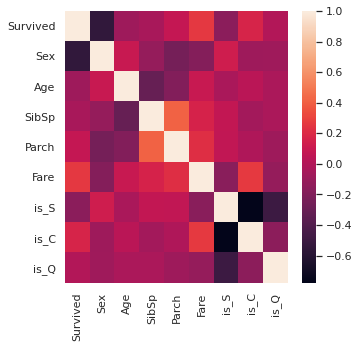

In [9]:
corr = dataTrain.corr()

sns.set(rc={'figure.figsize':(5, 5)})

sns.heatmap(corr,
           xticklabels = corr.columns.values,
           yticklabels = corr.columns.values)

После преобразования оценим корреляцию. (Теперь можем посмтреть корреляцию между портами и полами)
Заметим, что обратная ЛН между Sex и Survived. Делаем вывод, что спасали больше женщин.
Посмотрим общую информацию о данных:

### Удаление пропущенных значений

In [10]:
dataTrain.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 9 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Survived  891 non-null    int64  
 1   Sex       891 non-null    int64  
 2   Age       714 non-null    float64
 3   SibSp     891 non-null    int64  
 4   Parch     891 non-null    int64  
 5   Fare      891 non-null    float64
 6   is_S      891 non-null    int64  
 7   is_C      891 non-null    int64  
 8   is_Q      891 non-null    int64  
dtypes: float64(2), int64(7)
memory usage: 62.8 KB


Удалим тех у кого неопределен возраст. Исходя из целей ЛР и характера данных было принято считать, что возраст мог играть ключевой фактор в принятии решения о спасении пассажира. Принимает решение не учитывать данные 177 пассажиров. Вариант, при котором пассажирам без возраста назначался бы медианный, средний... возраст, мог сильно исказить реальное положение дел. 

In [11]:
# удаляем всех без возраста
dataTrain = dataTrain[dataTrain['Age'].notna()]
dataTrain.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 714 entries, 0 to 890
Data columns (total 9 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Survived  714 non-null    int64  
 1   Sex       714 non-null    int64  
 2   Age       714 non-null    float64
 3   SibSp     714 non-null    int64  
 4   Parch     714 non-null    int64  
 5   Fare      714 non-null    float64
 6   is_S      714 non-null    int64  
 7   is_C      714 non-null    int64  
 8   is_Q      714 non-null    int64  
dtypes: float64(2), int64(7)
memory usage: 55.8 KB


In [12]:
# проверим пропуски
dataTrain.isna().any()

Survived    False
Sex         False
Age         False
SibSp       False
Parch       False
Fare        False
is_S        False
is_C        False
is_Q        False
dtype: bool

### Проверка аномальных значений

<AxesSubplot:>

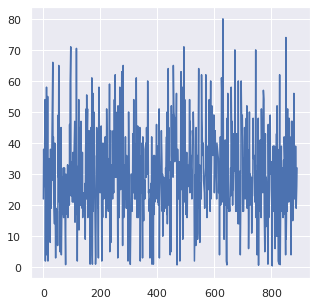

In [13]:
#посмотрим нет ли аномальных значений в признаках
dataTrain['Age'].plot()

<AxesSubplot:>

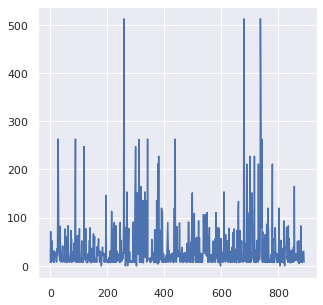

In [14]:
#посмотрим нет ли аномальных значений в признаках
dataTrain['Fare'].plot()

Замечаем несколько очень дорогих билетов, считаем, что на корабле могли присутствовать сильнообеспеченные персоны

### Загрузка тестовых данных

Зашрузим тестовые данные и выполним с ними такие же преобразования, как и с данными для обучения

In [15]:
# тестовые данные без результата
dataTest = pd.read_csv(dataPath + 'test.csv',sep=',')

# добавим результат в тест данные (так проще обрабатывать)
dataTestResult = pd.read_csv(dataPath + 'gender_submission.csv',sep=',')
dataTest['Survived'] = dataTestResult['Survived']

#dataTest['Id2'] = dataTestResult['PassengerId'] # было для сверки id пассажира

# обрабатываем тестовые данные также как и учебные
dataTest = dataTest.drop([ 'PassengerId','Name', 'Ticket', 'Cabin', 'Pclass'], axis='columns')

dataTest["Sex"] = dataTest['Sex'].apply(replace_sex)

oneHotEncoding(dataTest,'Embarked','S')
oneHotEncoding(dataTest, 'Embarked','C')
oneHotEncoding(dataTest, 'Embarked','Q')
dataTest = dataTest.drop(['Embarked'], axis='columns')


dataTest = dataTest[dataTest['Age'].notna()]


dataTest = dataTest[dataTest['Fare'].notna()]


dataTest.head(10)


,Sex,Age,SibSp,Parch,Fare,Survived,is_S,is_C,is_Q
0,1,34.5,0,0,7.8292,0,0,0,1
1,0,47.0,1,0,7.0000,1,1,0,0
2,1,62.0,0,0,9.6875,0,0,0,1
3,1,27.0,0,0,8.6625,0,1,0,0
4,0,22.0,1,1,12.2875,1,1,0,0
5,1,14.0,0,0,9.2250,0,1,0,0
6,0,30.0,0,0,7.6292,1,0,0,1
7,1,26.0,1,1,29.0000,0,1,0,0
8,0,18.0,0,0,7.2292,1,0,1,0
9,1,21.0,2,0,24.1500,0,1,0,0


In [16]:
### Метод ближайших соседей

In [17]:
# выделяем целевую переменную и данные для обучения и тестов
y_train = dataTrain['Survived']
dataTrain = dataTrain.drop(['Survived'], axis='columns')
X_train = dataTrain


y_test = dataTest['Survived']
dataTest = dataTest.drop(['Survived'], axis='columns')
X_test = dataTest


In [18]:
# проверяем размеры
print(len(X_train)==len(y_train), '\t' , len(X_test)==len(y_test))

True 	 True


In [19]:

#импорт класс классификатора по ближайшим соседям
from sklearn.neighbors import KNeighborsClassifier

clf = KNeighborsClassifier(n_neighbors = 5)

# обучение
clf.fit(X_train, y_train)

# тест
clf.score(X_test, y_test)

0.6132930513595166

Замечаем, что результат не достаточно высокий. Прогоним данные по разному кол-ву соседей

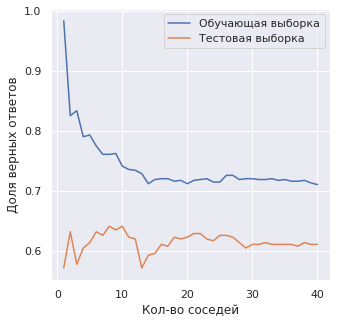

In [20]:
train_scores = {}
test_scores = {}


for n in range(1,41):
    clf = KNeighborsClassifier(n_neighbors = n)
    clf.fit(X_train, y_train)
    
    current_train_score = clf.score(X_train, y_train)
    train_scores[n] = current_train_score
    
    current_test_score = clf.score(X_test, y_test)
    test_scores[n] = current_test_score
    
    
plt.plot(train_scores.keys(), train_scores.values(), label='Обучающая выборка')

plt.plot(test_scores.keys(), test_scores.values(), label='Тестовая выборка')
plt.xlabel('Кол-во соседей')
plt.ylabel('Доля верных ответов')
plt.legend()
plt.show()


In [21]:
max = 0
maxN = 0
for n in range(1,len(test_scores) + 1):
    if max < test_scores[n]:
        max = test_scores[n]
        maxN = n
    print('n=' + str(n) + ':\t' + str(test_scores[n])[:4])

print('MAX:' + str(max) + '\tпри n=' + str(maxN))


n=1:	0.57
n=2:	0.63
n=3:	0.57
n=4:	0.60
n=5:	0.61
n=6:	0.63
n=7:	0.62
n=8:	0.64
n=9:	0.63
n=10:	0.64
n=11:	0.62
n=12:	0.61
n=13:	0.57
n=14:	0.59
n=15:	0.59
n=16:	0.61
n=17:	0.60
n=18:	0.62
n=19:	0.61
n=20:	0.62
n=21:	0.62
n=22:	0.62
n=23:	0.61
n=24:	0.61
n=25:	0.62
n=26:	0.62
n=27:	0.62
n=28:	0.61
n=29:	0.60
n=30:	0.61
n=31:	0.61
n=32:	0.61
n=33:	0.61
n=34:	0.61
n=35:	0.61
n=36:	0.61
n=37:	0.60
n=38:	0.61
n=39:	0.61
n=40:	0.61
MAX:0.6404833836858006	при n=8


### Вывод
Были отобраны и преобразованы данные для их дальнейшего применения в мат. модели. Был использован метод ближайших соседей. Было проверено варианты, где учитывались от 1 до 40 соседей. Оптимальное кол-во соседей: 8.
Точность на тестовой выборке достигла невысокого показателя 64%. И 65% при удалении порта (поле Embarked не участвует в расчетах) Метод ближних соседей не является оптимальным для данной задачи.